In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gseapy as gp
from gseapy.plot import dotplot
from reactome2py import analysis

In [2]:
disease_root = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/disease/'
disease_source = 'DIS_CAD'
diseasedf = pd.read_csv(disease_root+disease_source+'.tsv',sep='\t')
pos_genes = diseasedf['Gene']

In [3]:
def gene_enrich(genelist, type, sets=None, save=False):
    p_value = 0.05
    if type not in ["GO", "KEGG", "REACTOME", "WIKIPATHWAY"]:
        print("Type is not valid! it should be one of them GO, KEGG, REACTOME, WIKIPATHWAY")
    else:
        if type == "GO" and sets is None:
            sets = ["GO_Biological_Process_2021", "GO_Cellular_Component_2021", "GO_Molecular_Function_2021"]
        elif type == "KEGG" and sets is None:
            sets = ["KEGG_2016"]
        elif type == "REACTOME" and sets is None:
            sets = ["ReactomeGeneSets"]
        elif type == "WIKIPATHWAY" and sets is None:
            sets = ["WP2016"]
            
        if type in ["GO", "KEGG", "REACTOME", "WIKIPATHWAY"]:
            try:
                enr = gp.enrichr(gene_list=genelist,
                                gene_sets=sets,
                                organism='human',
                                #outdir=r"D:\study\thesis\project\HBDM-main\ppi_results\gene_enrichment",
                                cutoff=p_value)
                ax = dotplot(enr.res2d,
                            title=f"Gene ontology in {type} module",
                            cmap='viridis_r',
                            cutoff=p_value)
                ax.show()
            except:
                print(f"No enrich terms when cutoff = {p_value} in module {type}")
        else:
                numGeneModule = len(geneModule)
                geneModule = ",".join(geneModule)
                p_value = 0.05
                result = analysis.identifiers(ids=geneModule,
                                                species='Homo sapiens',
                                                p_value=str(p_value))
                token = result['summary']['token']
                if save == True:
                        analysis.report(token,
                                        path="/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/results/gene_enrich",
                                        file="report.pdf",
                                        number='50',
                                        species='Homo sapiens')
                token_result = analysis.token(token,
                        species='Homo sapiens',
                        p_value=str(p_value))

                print(
                f"{numGeneModule - token_result['identifiersNotFound']} out of {numGeneModule} genes (identifiers) in the sample were found in Reactome.")
                print(
                f"{token_result['resourceSummary'][0]['pathways']} pathways were hit by at least one of them, which {len(token_result['pathways'])} of them have p-value less than {p_value}.")
                print(f"For more information please visit https://reactome.org/PathwayBrowser/#/DTAB=AN&ANALYSIS={token}")

# WGCNA

In [4]:
import PyWGCNA


In [5]:
pyWGCNA_vsmc = PyWGCNA.readWGCNA("/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/scWGCNA/endo/sc_sub.p")

Reading sc_sub WGCNA done!


In [6]:
pyWGCNA_vsmc.datExpr.var['moduleColors'].value_counts()

darkgrey     2898
lightgrey    1566
black         203
gainsboro     196
silver        182
dimgrey       123
white          31
Name: moduleColors, dtype: int64

In [7]:
pyWGCNA_vsmc_df = pyWGCNA_vsmc.datExpr.var

In [8]:
pyWGCNA_vsmc_df['label'] = pyWGCNA_vsmc_df['features'].apply(lambda x: 1 if x in pos_genes.to_list() else 0)

In [9]:
pyWGCNA_vsmc_df[pyWGCNA_vsmc_df['label']==1]['moduleLabels'].value_counts()

1    306
4    238
0     42
3     33
5     33
2     22
6      4
Name: moduleLabels, dtype: int64

In [10]:
pyWGCNA_vsmc_df[pyWGCNA_vsmc_df['label']==1]['moduleLabels'].value_counts()/pyWGCNA_vsmc_df['moduleLabels'].value_counts()

1    0.105590
4    0.151980
0    0.206897
3    0.168367
5    0.181319
2    0.178862
6    0.129032
Name: moduleLabels, dtype: float64

No enrich terms when cutoff = 0.05 in module KEGG


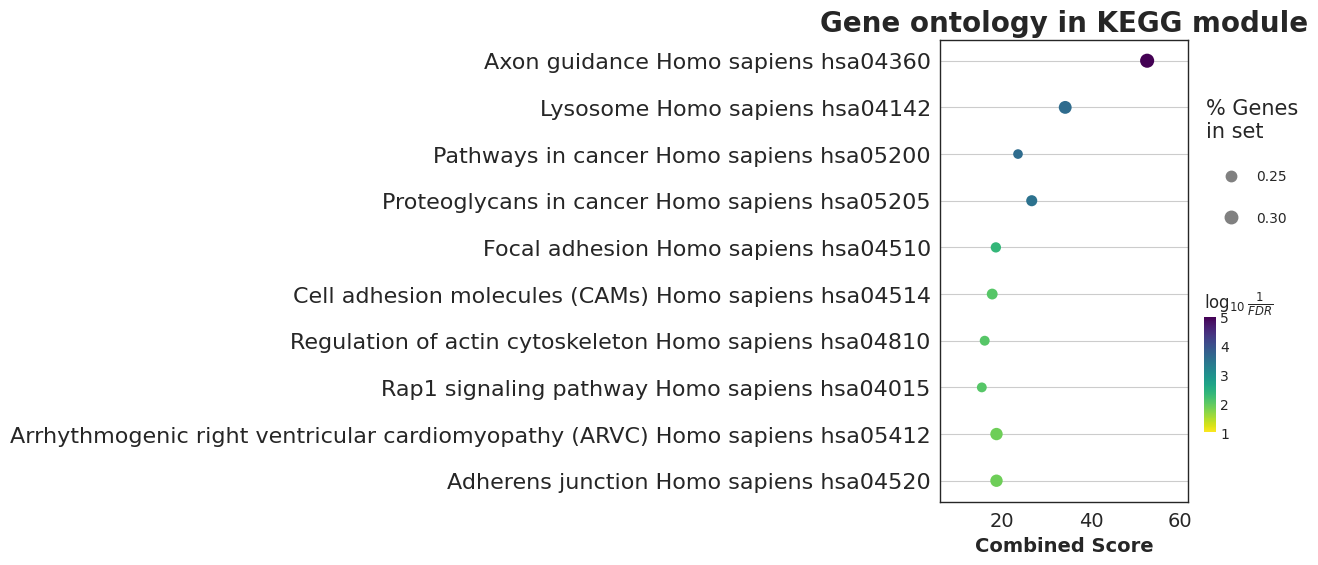

In [11]:
gene_enrich(pyWGCNA_vsmc_df[pyWGCNA_vsmc_df['moduleLabels']==1]['features'],'KEGG',sets=None,save=False)

No enrich terms when cutoff = 0.05 in module GO


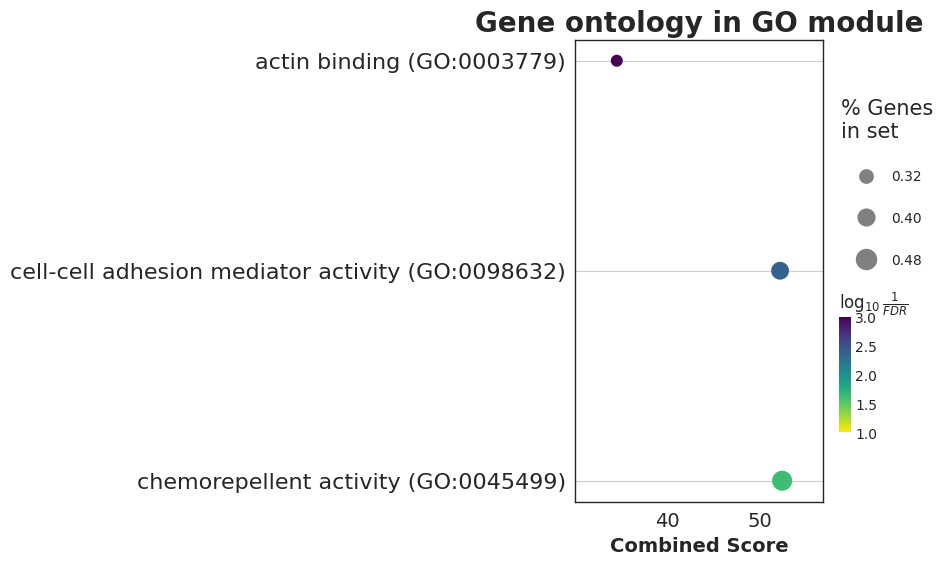

In [12]:
gene_enrich(pyWGCNA_vsmc_df[pyWGCNA_vsmc_df['moduleLabels']==1]['features'],'GO',sets=None,save=False)

No enrich terms when cutoff = 0.05 in module GO


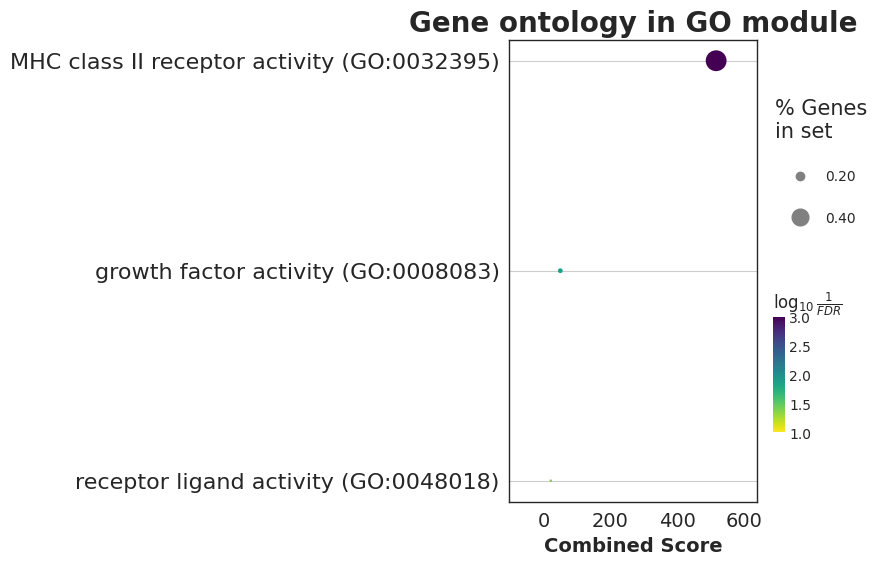

In [22]:
gene_enrich(pyWGCNA_vsmc_df[pyWGCNA_vsmc_df['moduleLabels']==4]['features'],'GO',sets=None,save=False)

No enrich terms when cutoff = 0.05 in module GO


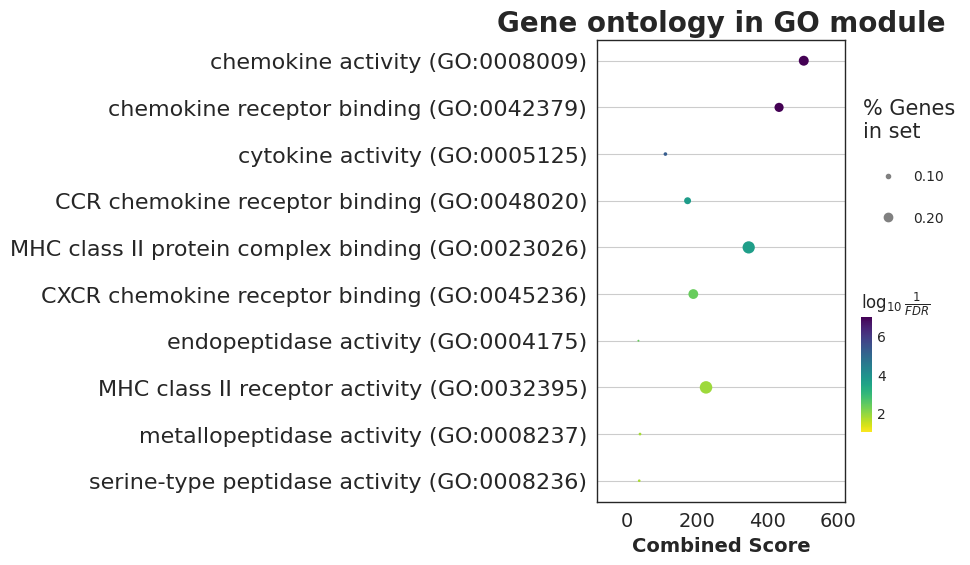

In [23]:
gene_enrich(pyWGCNA_vsmc_df[pyWGCNA_vsmc_df['moduleLabels']==3]['features'],'GO',sets=None,save=False)

No enrich terms when cutoff = 0.05 in module GO


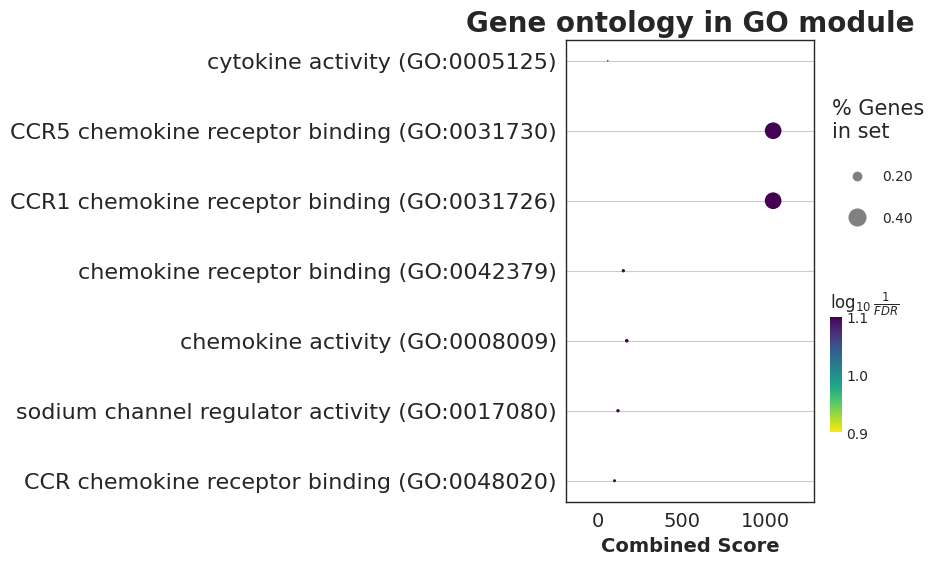

In [24]:
gene_enrich(pyWGCNA_vsmc_df[pyWGCNA_vsmc_df['moduleLabels']==0]['features'],'GO',sets=None,save=False)

No enrich terms when cutoff = 0.05 in module GO


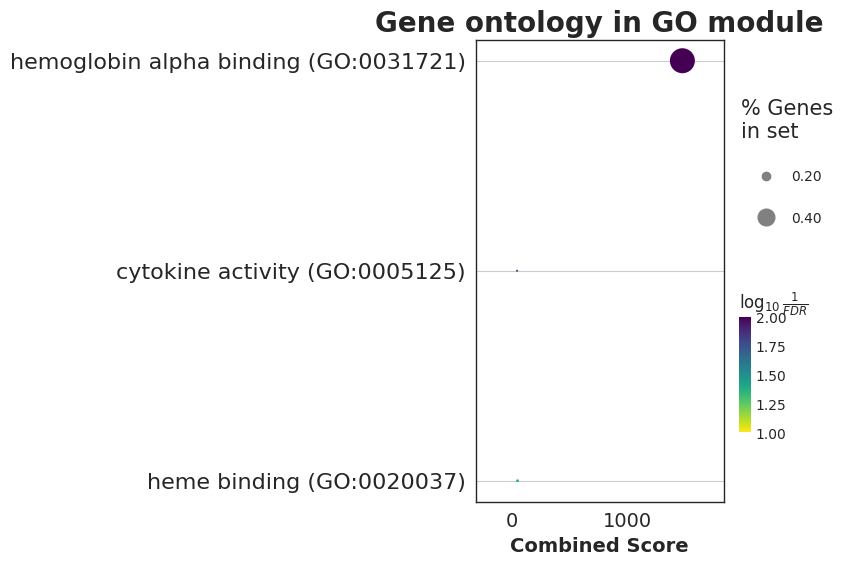

In [25]:
gene_enrich(pyWGCNA_vsmc_df[pyWGCNA_vsmc_df['moduleLabels']==2]['features'],'GO',sets=None,save=False)

# HBDM clustering

In [2]:
import pickle
import os
import networkx as nx
import scipy.cluster.hierarchy as sch

In [9]:
def overview(dataset):
    name = 'Dataset-'+dataset+'--RE-True--W-True--Epochs-15000--D-4--RH-25--LR-0.1--LP-False--CUDA-True'
    root = root = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/results/models/'+name
    variable_names = ['k_exp_dist', 'general_cl_id', 'general_mask']
    # Initialize a dictionary to store the loaded variables
    loaded_variables = {}

    # Loop through the variable names and load the data from pickle files
    for var_name in variable_names:
        file_path = os.path.join(root, var_name + '.pkl')
        with open(file_path, 'rb') as f:
            loaded_data = pickle.load(f)
        loaded_variables[var_name] = loaded_data

    # Access the loaded variables as needed
    k_exp_dist = loaded_variables['k_exp_dist']
    # final_idx = loaded_variables['final_idx']
    general_cl_id = loaded_variables['general_cl_id']
    general_mask = loaded_variables['general_mask']

    k_exp_dist = np.array(k_exp_dist)
    level_list = []
    # check the cluster ids in different levels
    for level, i in enumerate(general_cl_id):
        a = list(set(i))
        level_list.append(a)
        print(len(list(set(i))),' cluster num in level ',level+1)
    # Create your matrix of within-cluster Euclidean distances
    first_level_cls = len(set(list(general_cl_id[0])))
    distance_matrix = k_exp_dist[:first_level_cls,:first_level_cls]
    # Perform hierarchical clustering
    linkage_matrix = sch.linkage(distance_matrix, method='average')
    dendrogram = sch.dendrogram(linkage_matrix, color_threshold=0)
    order = dendrogram['leaves']
    return general_cl_id, general_mask, level_list,order

def hierachical_structure(dataset,general_cl_id, general_mask, level_list):
    index_dict = dict()
    for i, l in enumerate(general_cl_id):
        for j, cluster in enumerate(l):
            if cluster in index_dict:
                index_dict[cluster].append(general_mask[i][j])
            else:
                index_dict[cluster] = [general_mask[i][j]]
    level_dict = dict()
    for i in range(len(level_list)):
        if i == len(level_list)-1:
            l = level_list[i]
            for c1 in l:
                level_dict[c1] = []
        else:
            l = level_list[i]
            subl = level_list[i+1]
            # print(l,subl)
            for c1 in l:
                # print(c1)
                for c2 in subl:
                    # print(c2)
                    if set(index_dict[c1]) & set(index_dict[c2]):
                        # print(c2 ,'in',c1)
                        if c1 in level_dict:
                            level_dict[c1].append(c2)
                        else:
                            level_dict[c1] = [c2]
                if c1 not in level_dict:
                    level_dict[c1] = []

    ## get node and cluster
    df = pd.DataFrame({'node':range(max(list(set(general_mask[0])))+1)})
    for i, level in enumerate(general_cl_id):
        clusters = list(set(level))
        col = []
        ori_index = []
        colname = 'level_'+str(i+1)
        for key in clusters:
            col += len(index_dict[key])*[int(key)]
            ori_index.extend(index_dict[key])
        dftemp = pd.DataFrame({'node': ori_index, colname: col})
        df = df.merge(dftemp,how='left')
    convertpath = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/datasets/'+dataset+'/ppi_index.pkl'
    with open(convertpath, 'rb') as file:
        ppi_index = pickle.load(file)
    inv_dict = {v: k for k, v in ppi_index.items()}
    df['gene'] = df['node'].map(inv_dict)
    return df, index_dict

In [10]:
dataroot = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/datasets/sc_vsmc/'
 
 
sparse_i = np.loadtxt(dataroot+'sparse_i.txt')
sparse_j = np.loadtxt(dataroot+'sparse_j.txt')
sparse_w = np.loadtxt(dataroot+'sparse_w.txt')
 
sparse_i = sparse_i.astype(int)
sparse_j = sparse_j.astype(int)
sparse_w = sparse_w.astype(float)
 
# string_score_transform = np.vectorize(lambda x: -np.log(x/1000))
# transformed_w = string_score_transform(sparse_w)
# transformed_w = 11-(sparse_w*10).round()
edges_and_weights = zip(sparse_i, sparse_j,sparse_w)
 
G = nx.Graph()
 
# Use from_edgelist to directly create the graph from edges
G.add_weighted_edges_from(edges_and_weights)
# len(G.nodes)

9  cluster num in level  1
18  cluster num in level  2
36  cluster num in level  3
72  cluster num in level  4
140  cluster num in level  5
186  cluster num in level  6
122  cluster num in level  7
36  cluster num in level  8
16  cluster num in level  9


/tmp/ipykernel_1224136/3250271289.py:31: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method='average')


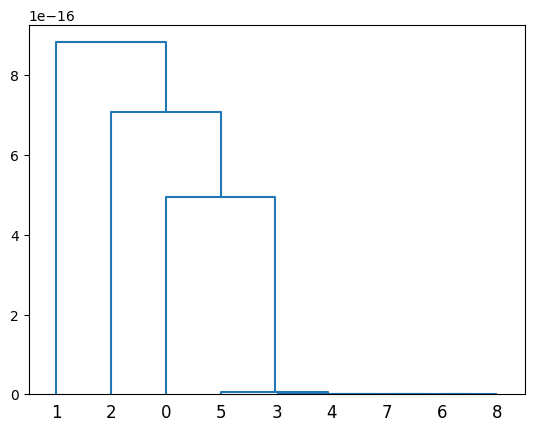

In [11]:
dataset = 'sc_vsmc'
general_cl_id, general_mask, level_list,order = overview(dataset)
sc_vsmc_hbdm,index_dict= hierachical_structure(dataset,general_cl_id, general_mask, level_list)

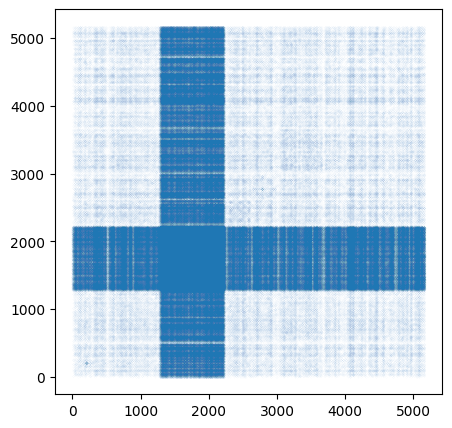

In [12]:
index = []
for i in order:
    index.extend(index_dict[i])
len(index)
ad = nx.to_numpy_array(G, dtype=bool, nodelist=index)
coords = np.argwhere(ad==True)
fig = plt.figure(figsize=(5, 5))
plt.scatter(coords[:,1],coords[:,0],s=0.00005)
plt.show()

In [8]:
sc_vsmc_hbdm['label'] = sc_vsmc_hbdm['gene'].apply(lambda x: 1 if x in pos_genes.to_list() else 0)

In [49]:
sc_vsmc_hbdm.to_csv('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/results/models/Dataset-sc_vsmc--RE-True--W-True--Epochs-15000--D-4--RH-25--LR-0.1--LP-False--CUDA-True/cluster.csv',index=False)

In [41]:
sc_vsmc_hbdm[sc_vsmc_hbdm['label']==1]['level_1'].value_counts()

0    202
4     88
7     79
2     76
1     53
8     53
5     44
6     43
3     34
Name: level_1, dtype: int64

No enrich terms when cutoff = 0.05 in module KEGG


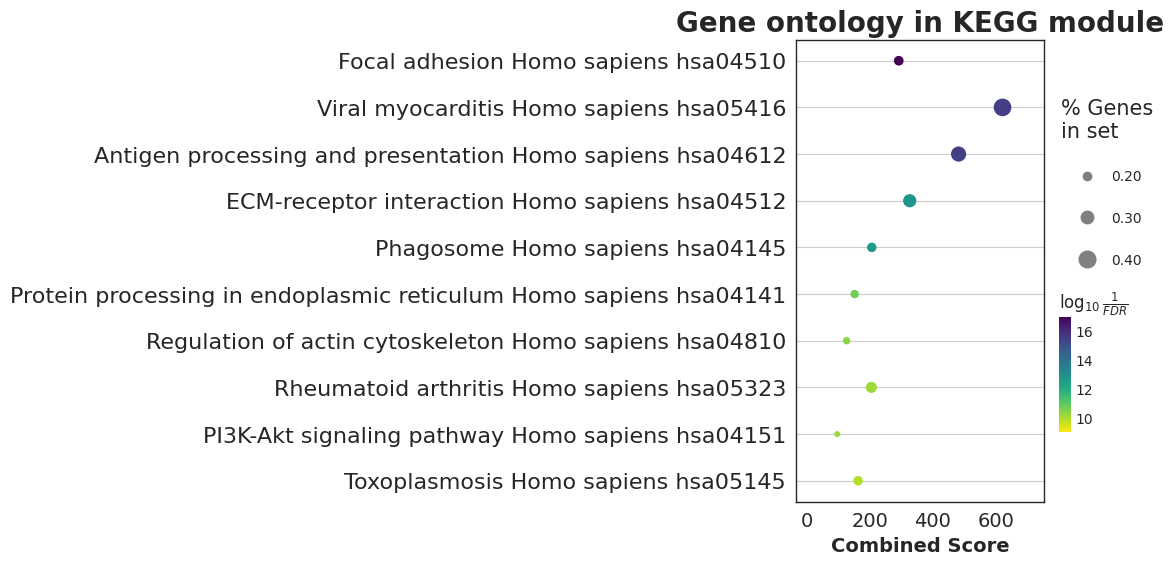

In [37]:
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_1']==0]['gene'],'KEGG',sets=None,save=False)

No enrich terms when cutoff = 0.05 in module GO


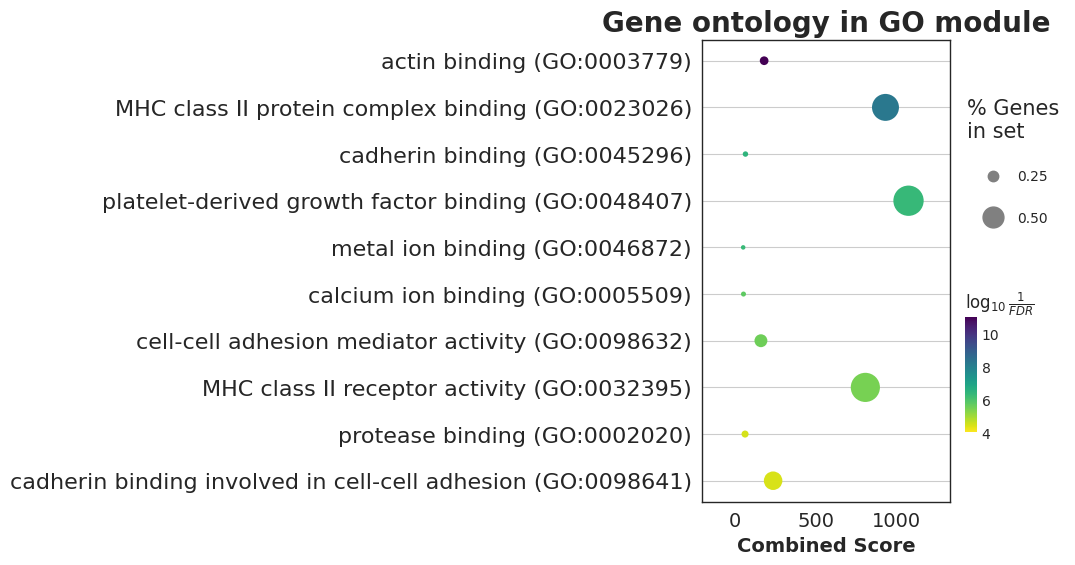

In [50]:
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_1']==0]['gene'],'GO',sets=None,save=False)

No enrich terms when cutoff = 0.05 in module KEGG
No enrich terms when cutoff = 0.05 in module GO


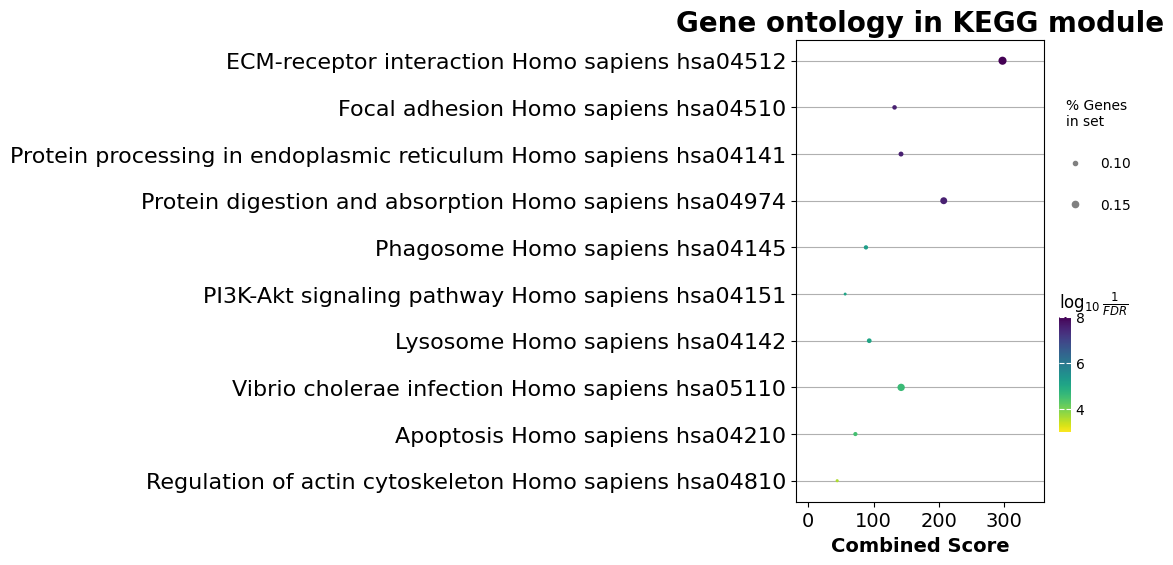

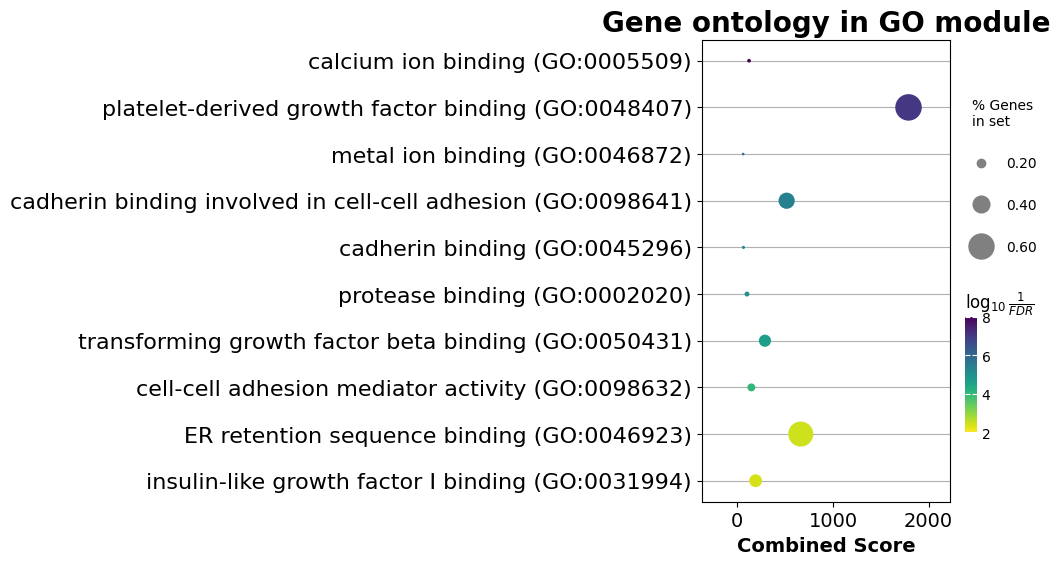

In [11]:
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_3']==30]['gene'],'KEGG',sets=None,save=False)
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_3']==30]['gene'],'GO',sets=None,save=False)

No enrich terms when cutoff = 0.05 in module KEGG
No enrich terms when cutoff = 0.05 in module GO


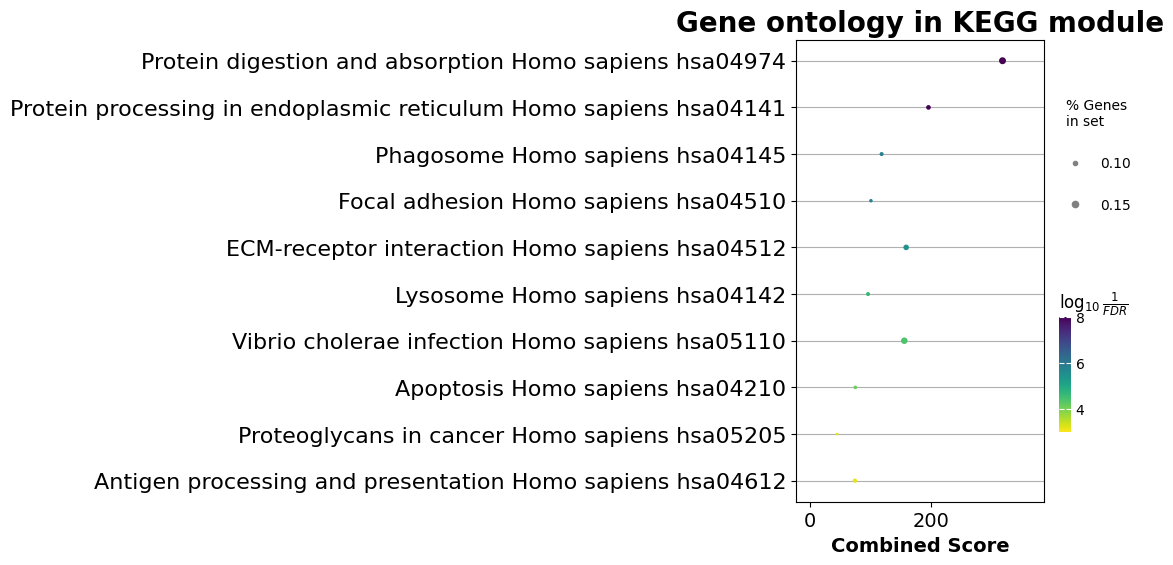

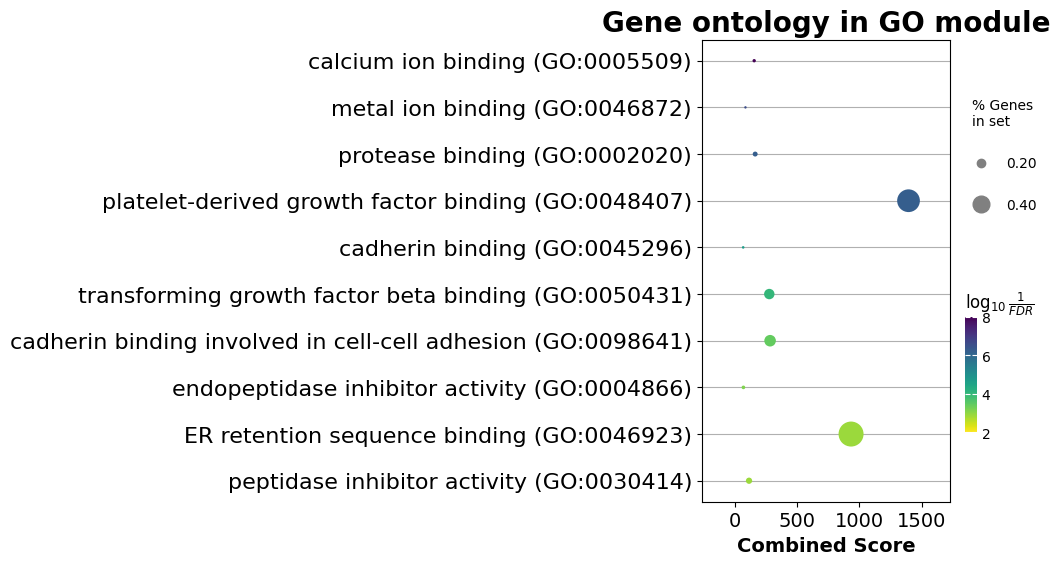

In [9]:
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_4']==69]['gene'],'KEGG',sets=None,save=False)
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_4']==69]['gene'],'GO',sets=None,save=False)

## high pre pos

No enrich terms when cutoff = 0.05 in module KEGG
No enrich terms when cutoff = 0.05 in module GO


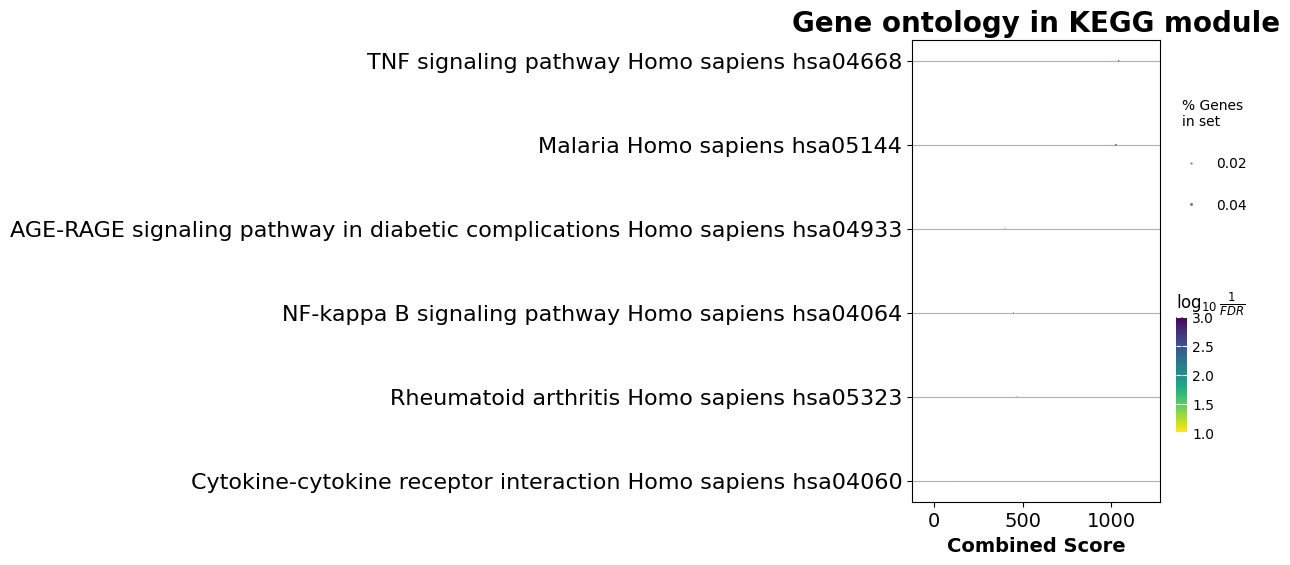

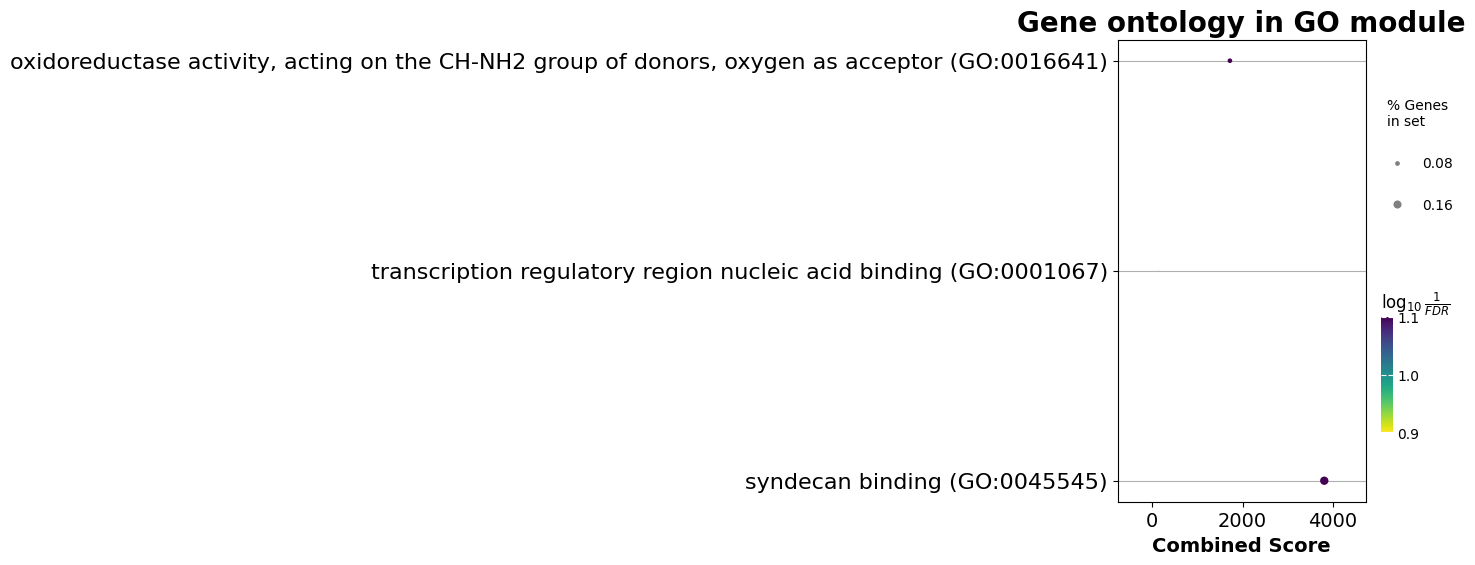

In [12]:
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_7']==473]['gene'],'KEGG',sets=None,save=False)
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_7']==473]['gene'],'GO',sets=None,save=False)

No enrich terms when cutoff = 0.05 in module KEGG
No enrich terms when cutoff = 0.05 in module GO


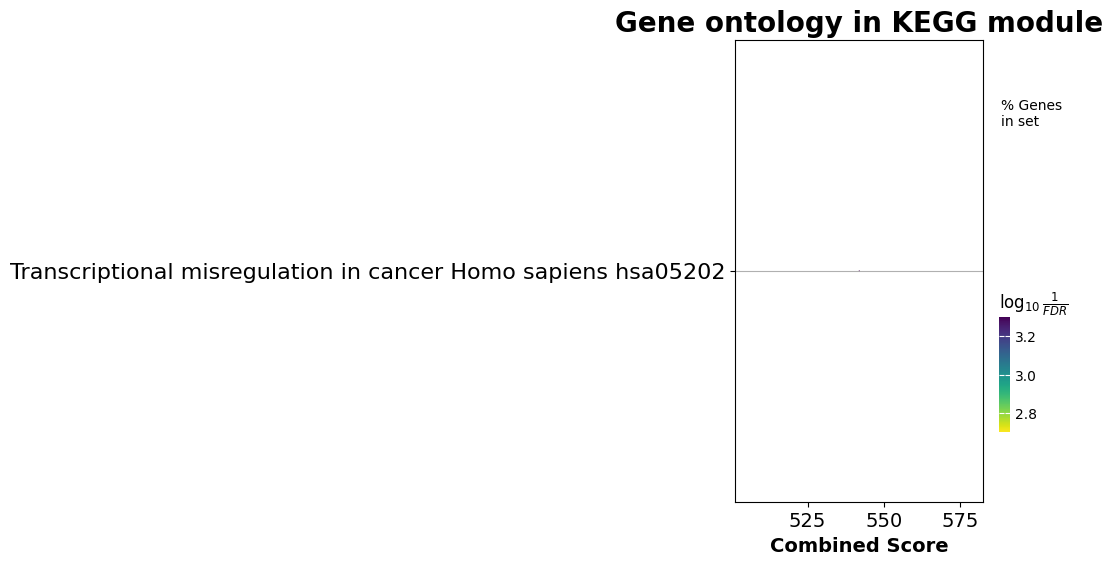

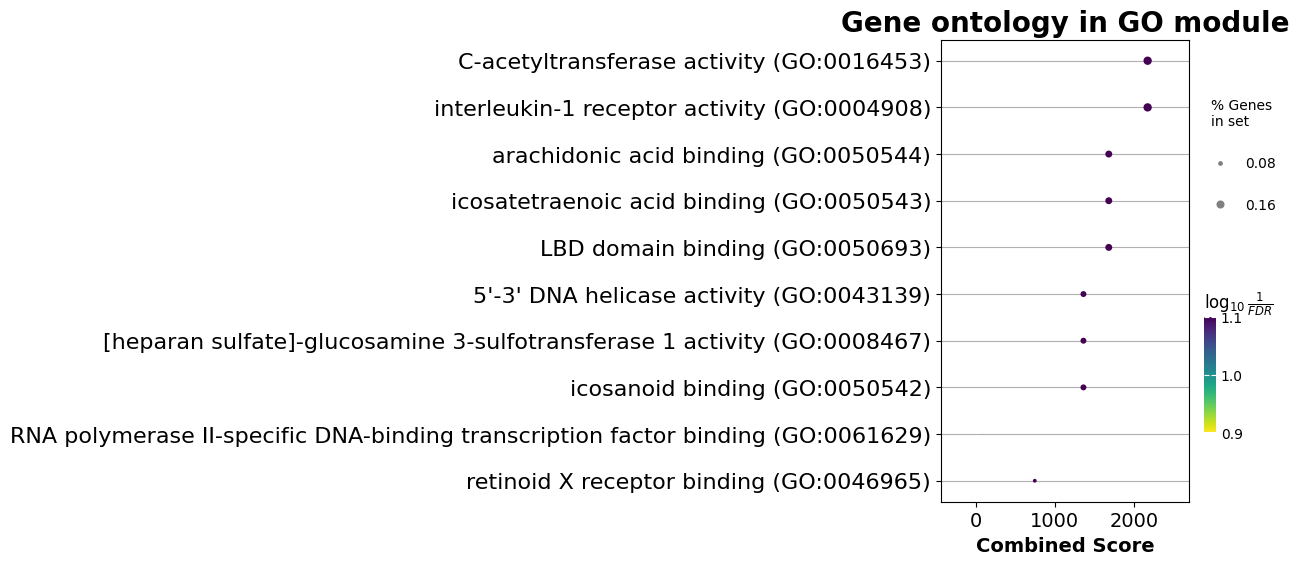

In [13]:
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_7']==547]['gene'],'KEGG',sets=None,save=False)
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_7']==547]['gene'],'GO',sets=None,save=False)

No enrich terms when cutoff = 0.05 in module KEGG
No enrich terms when cutoff = 0.05 in module GO


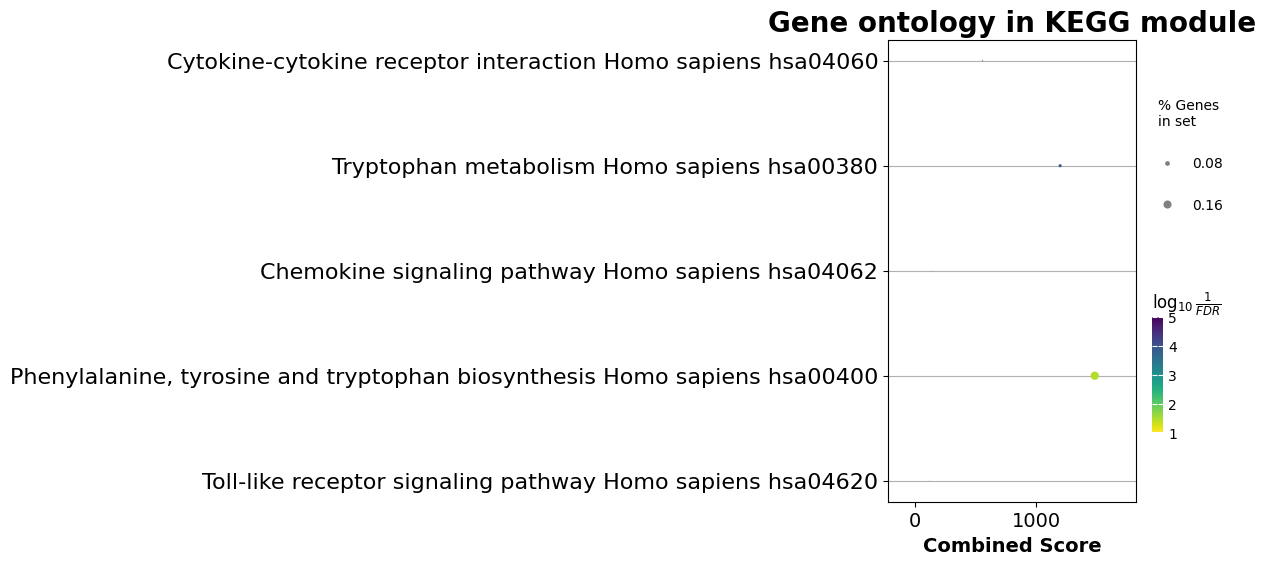

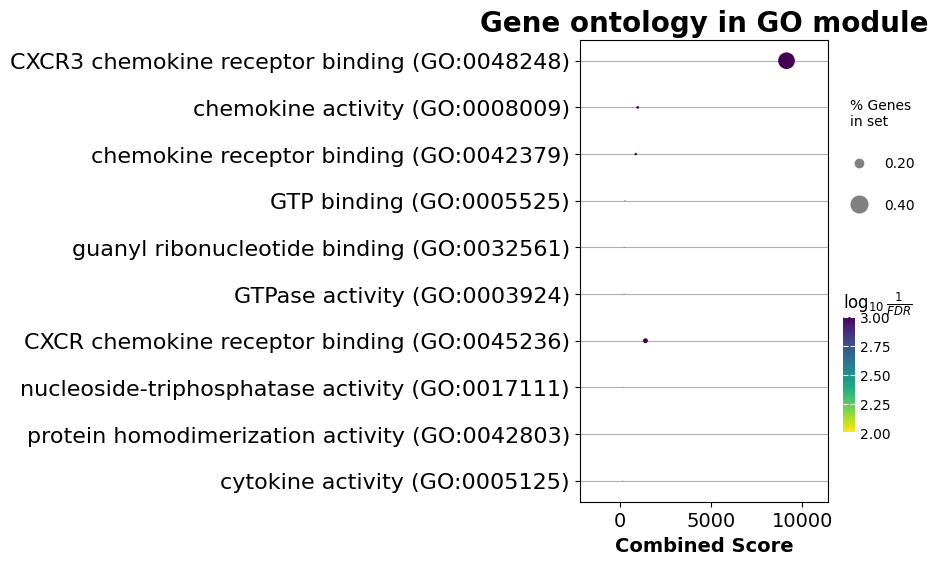

In [14]:
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_7']==471]['gene'],'KEGG',sets=None,save=False)
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_7']==471]['gene'],'GO',sets=None,save=False)

No enrich terms when cutoff = 0.05 in module KEGG
No enrich terms when cutoff = 0.05 in module GO


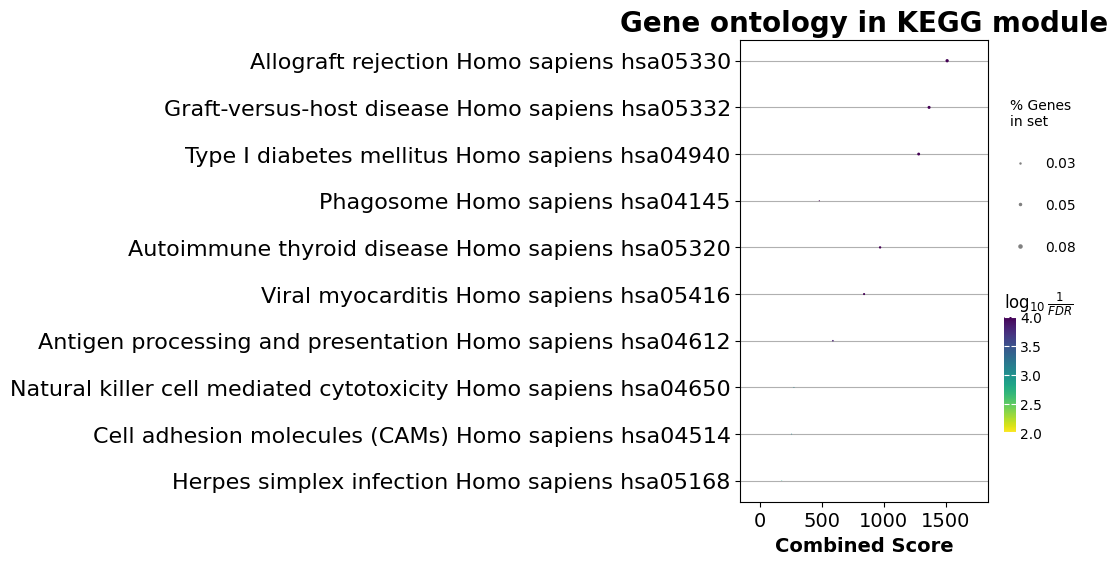

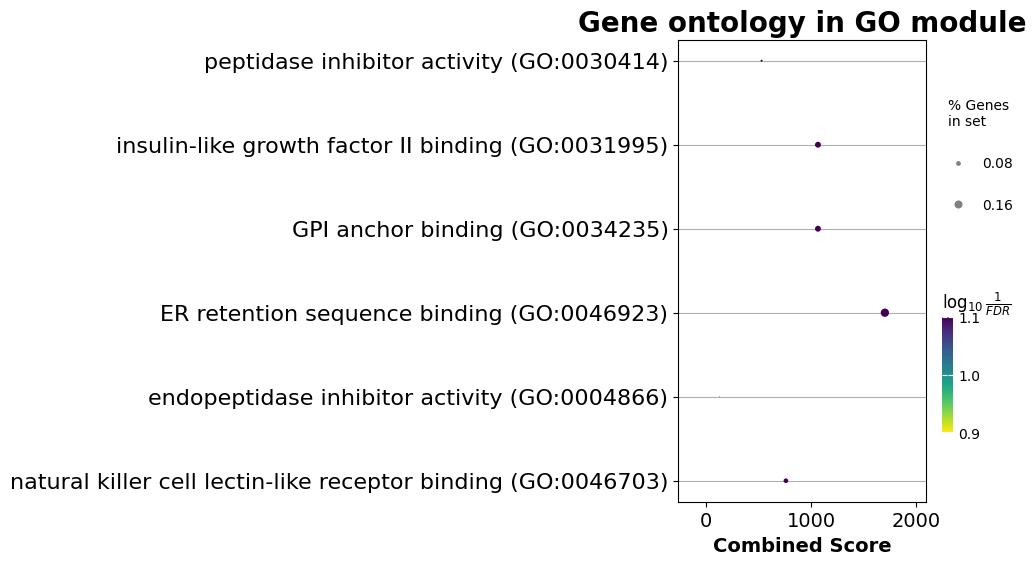

In [15]:
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_9']==623]['gene'],'KEGG',sets=None,save=False)
gene_enrich(sc_vsmc_hbdm[sc_vsmc_hbdm['level_9']==623]['gene'],'GO',sets=None,save=False)